Datasets

- MicroMed: https://github.com/IBMMRL/medinfo2015
- CADEC: https://data.csiro.au/collection/csiro:10948?q=CADEC&_st=keyword&_str=1&_si=1
- MedRed and Reddit 500k: https://figshare.com/articles/dataset/MedRed/12039609/1

Train models used in the paper.

**Before running** make sure to go through data preparation notebooks `micromed_prep.ipynb`, `cadec_prep.ipynb`, and `NER_prep.ipynb` to obtain and preprocess data into correct inputs.

---

In [2]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, PooledFlairEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from typing import List
from collections import defaultdict
import os
import re


In [22]:
# # included for convenience to help find correct paths
# import os
# os.getcwd()
# os.listdir("..")

Constants.

In [3]:
MEDRED_REPRODUCIBLE_DIR = "../"
MEDRED_LABELS_DIR = MEDRED_REPRODUCIBLE_DIR + "data/AMT/labels"
MICROMED_LABELS_DIR = MEDRED_REPRODUCIBLE_DIR + "data/Micromed"
CADEC_LABELS_DIR = MEDRED_REPRODUCIBLE_DIR + "data/cadec"

Model training code.

In [8]:
def read_in_data(path):

	files = os.listdir(path)
	regex = re.compile(".*(_train|_dev|_test).*")
	files = list(filter(regex.match, files))

	# define columns
	columns = {0: 'text', 1: 'ner'}

	# init a corpus using column format, data folder and the names of the train, dev and test files
	corpus: Corpus = ColumnCorpus(path, columns,
	                              train_file=files[2],
	                              test_file=files[1],
	                              dev_file=files[0])
	return corpus



def train(model, selected_embeddings):
	# 1. load data
	if model == "MedRed":
		corpus = read_in_data(MEDRED_LABELS_DIR)
	elif model == "Micromed":
		corpus = read_in_data(MICROMED_LABELS_DIR)
	elif model == "CADEC":
		corpus = read_in_data(CADEC_LABELS_DIR)
	else:
		raise ValueError("`model` must be one of MedRec, Micromed, CADEC.")	

	# 2. what tag do we want to predict?
	tag_type = 'ner'

	# 3. make the tag dictionary from the corpus
	# modified call, replaced deprecated
	tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)
	# tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

	# 4. select embedding types
	embedding_types: List[TokenEmbeddings] = []
	if selected_embeddings['glove']:
		embedding_types.append(WordEmbeddings('glove'))
	# RoBERTa via TransformerWordEmbeddings
	if selected_embeddings['roberta']:
		embedding_types.append(TransformerWordEmbeddings('roberta-base')) # modified from old version
	# PooledFlairEmbeddings
	if selected_embeddings['pooled-flair']:
		embedding_types.append(PooledFlairEmbeddings('news-forward', pooling='mean'))
	# PooledFlairEmbeddings
	if selected_embeddings['pooled-flair']:
		embedding_types.append(PooledFlairEmbeddings('news-backward', pooling='mean'))
	# StackedEmbeddings
	embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

	# 5. config tagger for sequences
	tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                          embeddings=embeddings,
                                          tag_dictionary=tag_dictionary,
                                          tag_type=tag_type,
                                          use_crf=True
                                          )
	# 6. set up training object
	trainer: ModelTrainer = ModelTrainer(tagger, corpus)

	# set up string to label model output, joining embedding types passed in
	selected_embeddings_text = [key  for key in selected_embeddings if selected_embeddings[key]]
	selected_embeddings_text = '_'.join(selected_embeddings_text)
	model_dir = MEDRED_REPRODUCIBLE_DIR + 'resources/taggers/FA_' + model + '_' + selected_embeddings_text

	# 7. start training
	trainer.train(model_dir,
				  train_with_dev=True,
				  learning_rate=0.1,
				  patience=3,
				  anneal_factor=0.5,
				  min_learning_rate=0.0001,
				  mini_batch_size=4,
				  max_epochs=200,
				  write_weights=True,
				  create_loss_file=True,
				  checkpoint=True)

	# 8. plot training curves
	from flair.visual.training_curves import Plotter
	plotter = Plotter()
	plotter.plot_training_curves(model_dir + '/loss.tsv')




2022-05-06 20:52:13,057 Reading data from ..\data\AMT\labels
2022-05-06 20:52:13,058 Train: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_train.csv
2022-05-06 20:52:13,059 Dev: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_dev.csv
2022-05-06 20:52:13,059 Test: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_test.csv
2022-05-06 20:52:15,125 Computing label dictionary. Progress:


968it [00:00, 49645.23it/s]

2022-05-06 20:52:15,146 Dictionary created for label 'ner' with 3 values: DIS (seen 1428 times), DRUG (seen 403 times)


2022-05-06 20:52:24,203 SequenceTagger predicts: Dictionary with 9 tags: O, S-DIS, B-DIS, E-DIS, I-DIS, S-DRUG, B-DRUG, E-DRUG, I-DRUG
2022-05-06 20:52:24,241 ----------------------------------------------------------------------------------------------------
2022-05-06 20:52:24,244 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): TransformerWordEmbeddings(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
            

100%|██████████| 135/135 [00:21<00:00,  6.30it/s]

2022-05-07 02:00:36,311 Evaluating as a multi-label problem: False
2022-05-07 02:00:36,323 0.702	0.6803	0.6909	0.5307
2022-05-07 02:00:36,324 
Results:
- F-score (micro) 0.6909
- F-score (macro) 0.7097
- Accuracy 0.5307

By class:
              precision    recall  f1-score   support

         DIS     0.6943    0.6528    0.6729       769
        DRUG     0.7240    0.7702    0.7464       235

   micro avg     0.7020    0.6803    0.6909      1004
   macro avg     0.7092    0.7115    0.7097      1004
weighted avg     0.7013    0.6803    0.6901      1004

2022-05-07 02:00:36,325 ----------------------------------------------------------------------------------------------------
2022-05-07 02:00:36,329 ----------------------------------------------------------------------------------------------------
2022-05-07 02:00:36,330 WARNING: No LOSS found for test split in this data.
2022-05-07 02:00:36,331 Are you sure you want to plot LOSS and not another value?
2022-05-07 02:00:36,331 ----------


No handles with labels found to put in legend.


2022-05-07 02:00:36,966 Loss and F1 plots are saved in ..\resources\taggers\FA_MedRed_glove_roberta\training.png


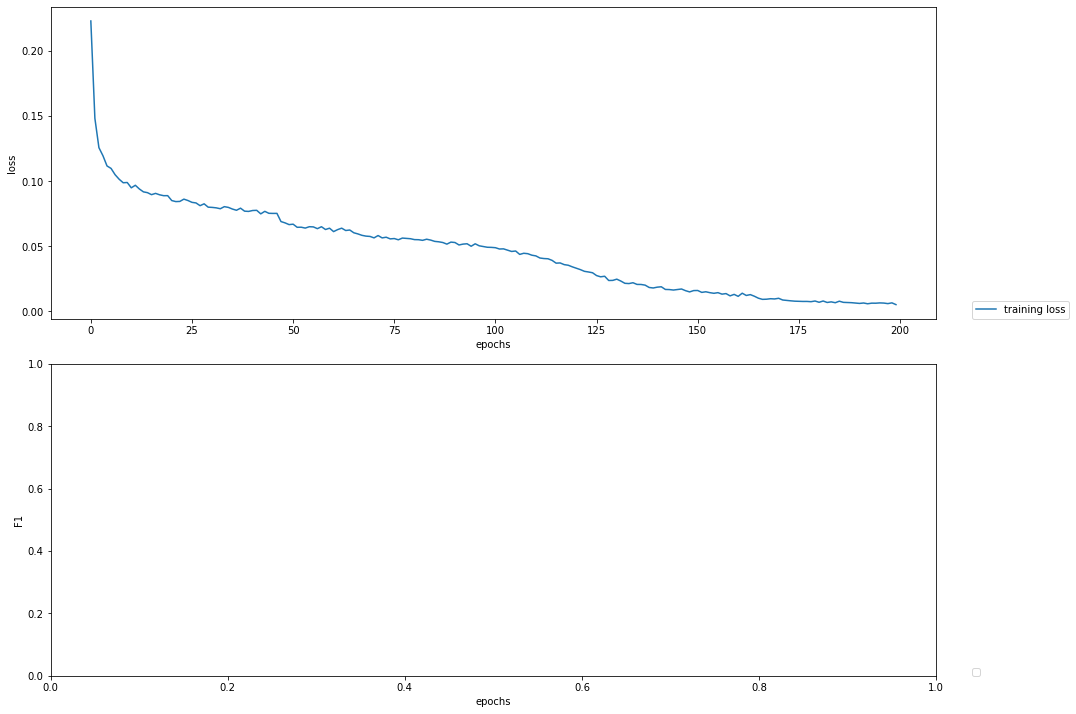

In [18]:
model = 'MedRed'
selected_embeddings = defaultdict(lambda: 0, {'glove':1, 'roberta':1})
train(model, selected_embeddings)

2022-05-07 02:01:58,799 Reading data from ..\data\Micromed
2022-05-07 02:01:58,800 Train: ..\data\Micromed\NER_Micromed_labels_train.csv
2022-05-07 02:01:58,801 Dev: ..\data\Micromed\NER_Micromed_labels_dev.csv
2022-05-07 02:01:58,802 Test: ..\data\Micromed\NER_Micromed_labels_test.csv
2022-05-07 02:01:58,872 Computing label dictionary. Progress:


133it [00:00, 33258.36it/s]

2022-05-07 02:01:58,879 Dictionary created for label 'ner' with 3 values: DIS (seen 148 times), DRUG (seen 56 times)


2022-05-07 02:02:08,035 SequenceTagger predicts: Dictionary with 9 tags: O, S-DIS, B-DIS, E-DIS, I-DIS, S-DRUG, B-DRUG, E-DRUG, I-DRUG
2022-05-07 02:02:08,070 ----------------------------------------------------------------------------------------------------
2022-05-07 02:02:08,073 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): TransformerWordEmbeddings(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
            

100%|██████████| 17/17 [00:00<00:00, 18.19it/s]

2022-05-07 02:20:13,766 Evaluating as a multi-label problem: False
2022-05-07 02:20:13,773 0.6947	0.7674	0.7293	0.5739
2022-05-07 02:20:13,774 
Results:
- F-score (micro) 0.7293
- F-score (macro) 0.7301
- Accuracy 0.5739

By class:
              precision    recall  f1-score   support

         DIS     0.6711    0.7969    0.7286        64
        DRUG     0.7895    0.6818    0.7317        22

   micro avg     0.6947    0.7674    0.7293        86
   macro avg     0.7303    0.7393    0.7301        86
weighted avg     0.7013    0.7674    0.7294        86

2022-05-07 02:20:13,774 ----------------------------------------------------------------------------------------------------
2022-05-07 02:20:13,777 ----------------------------------------------------------------------------------------------------
2022-05-07 02:20:13,777 WARNING: No LOSS found for test split in this data.
2022-05-07 02:20:13,777 Are you sure you want to plot LOSS and not another value?
2022-05-07 02:20:13,778 ---------


No handles with labels found to put in legend.


2022-05-07 02:20:14,399 Loss and F1 plots are saved in ..\resources\taggers\FA_Micromed_glove_roberta\training.png


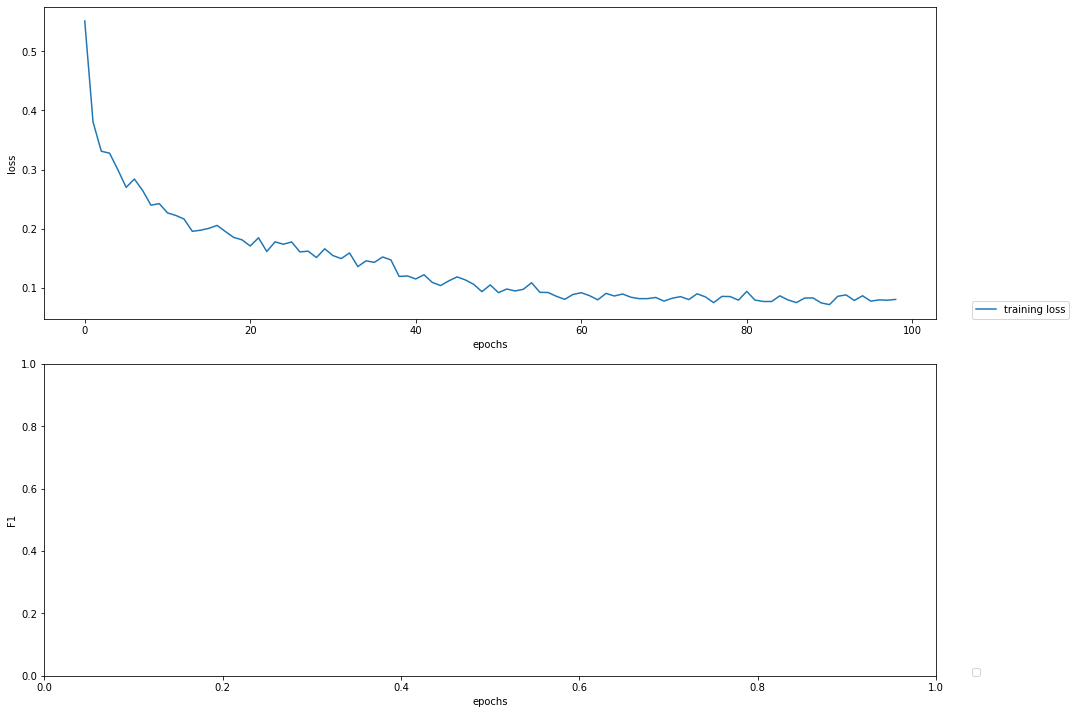

In [19]:
model = 'Micromed'
selected_embeddings = defaultdict(lambda: 0, {'glove':1, 'roberta':1})
train(model, selected_embeddings)

2022-05-08 01:54:21,145 Reading data from ..\data\cadec
2022-05-08 01:54:21,146 Train: ..\data\cadec\NER_CADEC_labels_train.csv
2022-05-08 01:54:21,146 Dev: ..\data\cadec\NER_CADEC_labels_dev.csv
2022-05-08 01:54:21,147 Test: ..\data\cadec\NER_CADEC_labels_test.csv
2022-05-08 01:54:22,301 Computing label dictionary. Progress:


434it [00:00, 39370.36it/s]

2022-05-08 01:54:22,314 Dictionary created for label 'ner' with 3 values: DRUG (seen 866 times), DIS (seen 189 times)


2022-05-08 01:54:31,542 SequenceTagger predicts: Dictionary with 9 tags: O, S-DRUG, B-DRUG, E-DRUG, I-DRUG, S-DIS, B-DIS, E-DIS, I-DIS
2022-05-08 01:54:31,566 ----------------------------------------------------------------------------------------------------
2022-05-08 01:54:31,568 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): TransformerWordEmbeddings(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
            

100%|██████████| 52/52 [00:12<00:00,  4.33it/s]

2022-05-08 03:32:25,369 Evaluating as a multi-label problem: False
2022-05-08 03:32:25,377 0.8918	0.8228	0.8559	0.7481
2022-05-08 03:32:25,378 
Results:
- F-score (micro) 0.8559
- F-score (macro) 0.6024
- Accuracy 0.7481

By class:
              precision    recall  f1-score   support

        DRUG     0.9074    0.9095    0.9085       431
         DIS     0.5714    0.2000    0.2963        60

   micro avg     0.8918    0.8228    0.8559       491
   macro avg     0.7394    0.5548    0.6024       491
weighted avg     0.8664    0.8228    0.8337       491

2022-05-08 03:32:25,378 ----------------------------------------------------------------------------------------------------
2022-05-08 03:32:25,381 ----------------------------------------------------------------------------------------------------
2022-05-08 03:32:25,381 WARNING: No LOSS found for test split in this data.
2022-05-08 03:32:25,381 Are you sure you want to plot LOSS and not another value?
2022-05-08 03:32:25,383 ---------

2022-05-08 03:32:25,397 WARNING: No F1 found for test split in this data.
2022-05-08 03:32:25,398 Are you sure you want to plot F1 and not another value?
2022-05-08 03:32:25,399 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


2022-05-08 03:32:25,982 Loss and F1 plots are saved in ..\resources\taggers\FA_CADEC_glove_roberta\training.png


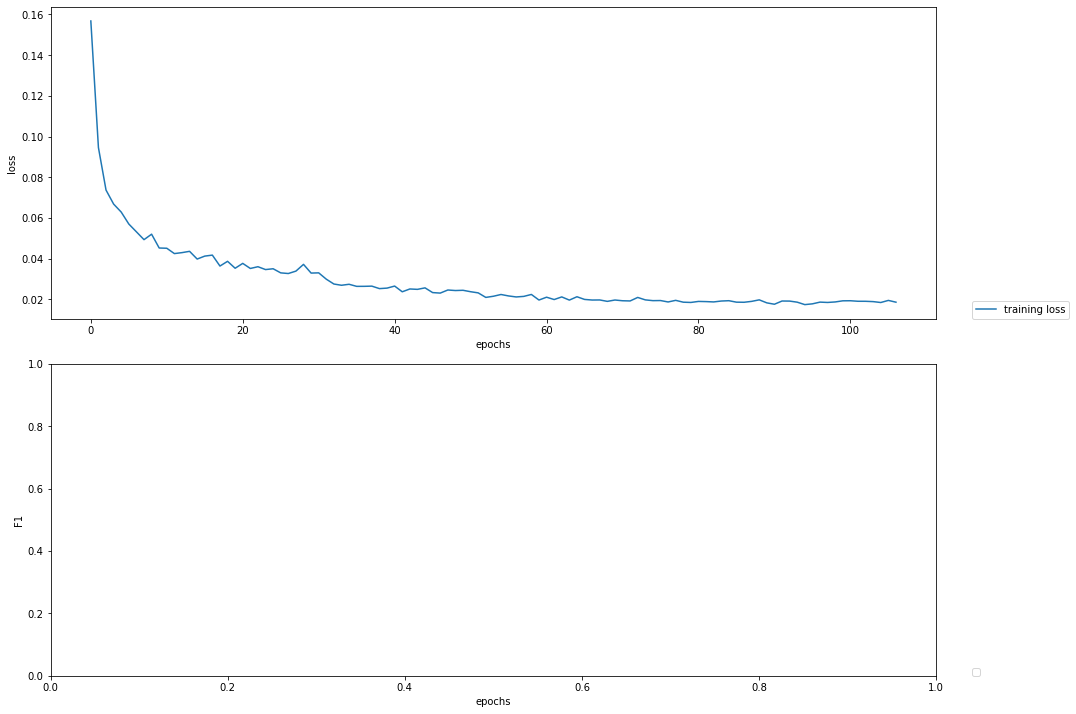

In [6]:
model = 'CADEC'
selected_embeddings = defaultdict(lambda: 0, {'glove':1, 'roberta':1})
train(model, selected_embeddings)

2022-05-08 15:17:12,879 Reading data from ..\data\AMT\labels
2022-05-08 15:17:12,902 Train: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_train.csv
2022-05-08 15:17:12,918 Dev: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_dev.csv
2022-05-08 15:17:12,918 Test: ..\data\AMT\labels\NER_Reddit_AMT_labels_href_test.csv
2022-05-08 15:17:31,922 Computing label dictionary. Progress:


968it [00:00, 48394.28it/s]

2022-05-08 15:17:31,987 Dictionary created for label 'ner' with 3 values: DIS (seen 1428 times), DRUG (seen 403 times)


2022-05-08 15:18:06,983 SequenceTagger predicts: Dictionary with 9 tags: O, S-DIS, B-DIS, E-DIS, I-DIS, S-DRUG, B-DRUG, E-DRUG, I-DRUG
2022-05-08 15:18:07,783 ----------------------------------------------------------------------------------------------------
2022-05-08 15:18:07,784 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): PooledFlairEmbeddings(
      (context_embeddings): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (list_embedding_1): PooledFlairEmbeddings(
      (context_embeddings): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=T

100%|██████████| 135/135 [00:46<00:00,  2.93it/s]

2022-05-08 18:29:28,679 Evaluating as a multi-label problem: False
2022-05-08 18:29:28,724 0.7768	0.6135	0.6856	0.5251


2022-05-08 18:29:28,725 
Results:
- F-score (micro) 0.6856
- F-score (macro) 0.6947
- Accuracy 0.5251

By class:
              precision    recall  f1-score   support

         DIS     0.7720    0.6034    0.6774       769
        DRUG     0.7917    0.6468    0.7119       235

   micro avg     0.7768    0.6135    0.6856      1004
   macro avg     0.7819    0.6251    0.6947      1004
weighted avg     0.7766    0.6135    0.6855      1004

2022-05-08 18:29:28,727 ----------------------------------------------------------------------------------------------------
2022-05-08 18:29:28,742 ----------------------------------------------------------------------------------------------------
2022-05-08 18:29:28,745 WARNING: No LOSS found for test split in this data.
2022-05-08 18:29:28,749 Are you sure you want to plot LOSS and not another value?
2022-05-08 18:29:28,752 ----------------------------------------------------------------------------------------------------
2022-05-08 18:29:28,811 ---

No handles with labels found to put in legend.


2022-05-08 18:29:29,448 Loss and F1 plots are saved in ..\resources\taggers\FA_MedRed_pooled-flair\training.png


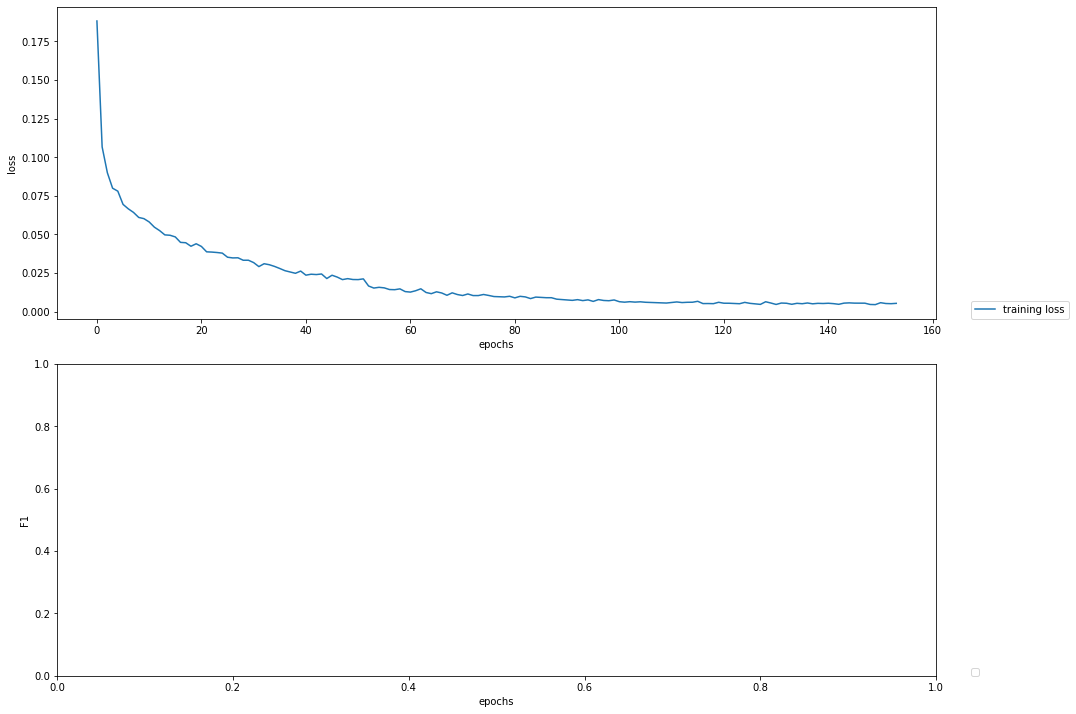

In [9]:
model = 'MedRed'
selected_embeddings = defaultdict(lambda: 0, {'pooled-flair':1})
train(model, selected_embeddings)